In [1]:
import os
import warnings

import pandas as pd
import numpy as np


from jre_utils.datapath import (
    DATA_DIRECTORY_PATH,
)
from jre_utils.config import asset_types
from jp_prefecture.jp_cities import JpCity, jp_cities
from geopy.geocoders import Nominatim

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [2]:
def area_to_int(area):
    if area == "2,000 m^2 or greater.":
        return 2000
    elif area == "5000 m^2 or greater.":
        return 5000
    else:
        return int(area)


def map_time_units(x):
    mapping = {
        "30-60minutes": 45,
        "1H-1H30": 75,
        "1H30-2H": 105,
        "2H-": 135,
    }
    
    return int(x) if x.isdigit() else mapping[x]

def map_layout(x):
    if x == "na":
        return "na"

    x = x.split("+")[0]

    if x[0].isdigit() and int(x[0]) == 1:
        if x != "1K" and x != "1LDK" and x != "1DK":
            return "1other"
        return x
    
    if x[0].isdigit() and int(x[0]) == 2:
        if x != "2LDK" and x != "2DK":
            return "2other"
        return x

    if x[0].isdigit() and int(x[0]) > 2:
        return f"{min(int(x[0]), 5)}LDK"
    
    return "other"

def map_land_shape(x):
    x = x.lower()
    x = x.replace("semi-", "")
    return x

def map_frontage(x):
    if x == "na":
        return 0
    if x == "50.0m or longer.":
        return 55
    return int(x.split(".")[0])

def map_floor_area(x):
    if "less" in x:
        return 10
    elif "greater" in x:
        return 2000
    else:
        return int(x)
    
def map_year_of_construction(x):
    if x == "before the war":
        return 1930
    
    return int(x)

In [3]:
import json
from pprint import pprint

sub_city_to_city_path = f"{DATA_DIRECTORY_PATH}/core_scraped/sub_city_to_city.json"
with open(sub_city_to_city_path) as fd:
     sub_city_to_city = json.load(fd)
     pprint(f"E.g. Maps 1101 to {sub_city_to_city['1101']}")

area_code_to_area_path = f"{DATA_DIRECTORY_PATH}/core_scraped/area_code_to_area.json"
with open(area_code_to_area_path) as fd:
     area_code_to_area = json.load(fd)
     pprint(f"E.g. Maps 1100 to {area_code_to_area['1100']}") 

def get_city_code(area_code):
     return sub_city_to_city.get(area_code, area_code)

def get_area_from_area_code(area_code):
     return area_code_to_area.get(area_code, "na" )

def get_city_geocode(area_code):
    area_code = str(area_code)
    try:
        return tuple(jp_cities.citycode2geodetic(area_code)) 
    except:
        print(f"Could not find geocode for {area_code}")
        return np.NaN, np.NaN
    
def find_town_jp(all_towns_df, city_code, town_name, log=False):
    city_df = all_towns_df[all_towns_df["cityCode"] == int(city_code)]
    town_df = city_df[city_df["townAlphabet"].str.contains(town_name)]
    
    if town_df.empty:
        if log:
            print(f"JP could not find {town_name} in {city_code}")
        return None, None
    
    return town_df["longitude"].mean(), town_df["latitude"].mean()

def find_town_geopy(geolocator, address, log=False):
    location_info = geolocator.geocode(address)

    if not location_info:
        if log:
            print(f"Geopy could not find {address}")
        return None, None
    
    return location_info.longitude, location_info.latitude

def get_town_coordinates_jp(all_towns_df, city_name, city_code, town_name, log=False):
    geolocator = Nominatim(user_agent="my_app")
    
    # Try to locade in df - this is fast
    jp_lon, jp_lat = find_town_jp(all_towns_df, city_code, town_name, log)

    if not jp_lon or not jp_lat:
        address = f"{town_name}, {city_name}, Japan"
        
        # Fall back and try to locate with geopy - this is slow
        geopy_lon, geopy_lat = find_town_geopy(geolocator, address, log)
        
        if not geopy_lon or not geopy_lat:
            # if nothing works, just return the city coordinates
            return get_city_geocode(city_code)
        
        return geopy_lon, geopy_lat

    return jp_lon, jp_lat



'E.g. Maps 1101 to 1100'
'E.g. Maps 1100 to Hokkaido Sapporo-shi'


In [199]:
prefecture_code = 15
trade_prices_data_path = f"{DATA_DIRECTORY_PATH}/core"

trade_prices_data_paths = [
    f"{trade_prices_data_path}/{filename}"
    for filename in sorted(os.listdir(trade_prices_data_path))
]
trade_prices_data_paths[prefecture_code - 1]

'../../data/core/15_Niigata Prefecture_20053_20233.csv'

In [200]:
df = pd.read_csv(
    trade_prices_data_paths[prefecture_code - 1],
    encoding="unicode_escape",
    index_col="No",
)
df["area_code"] = df["City,Town,Ward,Village code"].astype(str)

# we may want to skip the following step in the future
df["area_code"] = df["area_code"].apply(get_city_code).astype(str)
df["area"] = df["area_code"].apply(get_area_from_area_code)

df["trade_price"] = df["Transaction-price(total)"]
df["trade_area"] = df["Area(m^2)"].apply(area_to_int)
df["unit_price"] = df["Transaction-price(Unit price m^2)"]
df["trade_price_per_area"] = df["trade_price"] / df["trade_area"]

df["quarter"] = df["Transaction period"].apply(lambda x: int(x.split(" ")[0][0]))
df["year"] = df["Transaction period"].apply(lambda x: int(x.split(" ")[2]))

df["unit_price"] = np.where(
    df["unit_price"].isna(),
    df["trade_price_per_area"],
    df["unit_price"],
)

df = df[
    df["Type"].isin(
        [
            asset_types["building"]["label"],
            asset_types["land"]["label"],
            asset_types["condo"]["label"],
        ],
    )
]

# Renaming

df = df.rename(columns = {
    "Type": "asset_type",
    "Region": "neighbourhood_classification",
    "Area": "subarea",
    "Nearest stationFName": "nearest_station",
    "Nearest stationFDistance(minute)": "time_to_nearest_station",
    "Layout": "layout",
    "Land shape": "land_shape",
    "Frontage": "frontage",
    "Total floor area(m^2)": "total_floor_area",
    "Year of construction": "year_of_construction",
    "Building structure": "building_structure",
    "Use": "use",
    "Purpose of Use": "purpose",
    "Frontage roadFDirection": "frontage_road_direction",
    "Frontage roadFClassification": "frontage_road_classification",
    "Frontage roadFBreadth(m)": "frontage_road_breadth",
    "City Planning": "zone",
    "Maximus Building Coverage Ratio(%)": "max_building_coverage_ratio",
    "Maximus Floor-area Ratio(%)": "max_floor_area_ratio",
    "Renovation": "renovation_status",
    "Transactional factors": "transactional_factors", # need to format and include
})

# Process factors

df["subarea"] = df["subarea"].fillna("")
df["neighbourhood_classification"] = df["neighbourhood_classification"].fillna("na")
df["nearest_station"] = df["nearest_station"].fillna("na")
df["time_to_nearest_station"] = df["time_to_nearest_station"].fillna("30-60minutes").apply(map_time_units)
df["layout"] = df["layout"].fillna("na").apply(map_layout)
df["land_shape"] = df["land_shape"].fillna("na").map(map_land_shape)
df["frontage"] = df["frontage"].fillna("na").apply(map_frontage)

df["total_floor_area"] = np.where(
    df["total_floor_area"].isna(),
    df["trade_area"].astype(str),
    df["total_floor_area"],
)

df["total_floor_area"] = df["total_floor_area"].apply(map_floor_area)


df["year_of_construction"] = np.where(
    df["year_of_construction"].isna(),
    (df["year"] - 30).astype(str),
    df["year_of_construction"],
)

df["year_of_construction"] = df["year_of_construction"].apply(map_year_of_construction)
df["age"] = (df["year"] - df["year_of_construction"]).apply(lambda x: max(x, 0))

df["building_structure"] = df["building_structure"].fillna("na")
df["frontage_road_direction"] = df["frontage_road_direction"].fillna("na")
df["frontage_road_classification"] = df["frontage_road_classification"].fillna("na")
df["frontage_road_breadth"] = df["frontage_road_breadth"].fillna("0.0").astype(float)
df["zone"] = df["zone"].fillna("na")
df["max_building_coverage_ratio"] = df["max_building_coverage_ratio"].fillna(0)
df["max_floor_area_ratio"] = df["max_floor_area_ratio"].fillna(0)
df["renovation_status"] = df["renovation_status"].fillna("na")


df["use"] = df["use"].fillna("na")
df["purpose"] = df["purpose"].fillna("na")
df["transactional_factors"] = df["transactional_factors"].fillna("na")

df = df.drop(columns = [
    "City,Town,Ward,Village code",
    "City,Town,Ward,Village",
    "Transaction-price(total)",
    "Area(m^2)",
    "Transaction-price(Unit price m^2)",
    "trade_price_per_area",
    "Transaction period",
    "Prefecture",
])

In [201]:
# Convert towns into Longitude and Latitude
# jp_towns = JpCity(enable_town=True)
# towns_df = jp_towns.towns
# towns_df["townAlphabet"] = towns_df["townAlphabet"].fillna("")

# towns_list_df = df[["area", "area_code", "subarea"]].drop_duplicates()
# towns_list_df[["long", "lat"]] = towns_list_df.apply(
#     lambda x: pd.Series(get_town_coordinates_jp(towns_df, x["area"], x["area_code"], x["subarea"])),
#     axis=1,
# )

subarea_coords_simple_path = f"{DATA_DIRECTORY_PATH}/coordinates/subarea_simple.csv"
subarea_coords_simple_path = f"{DATA_DIRECTORY_PATH}/coordinates/subarea.csv"
coordinates_df = pd.read_csv(subarea_coords_simple_path)
coordinates_df["area_code"] = coordinates_df["area_code"].astype(str)

In [202]:
# Advanced preprocessing
df = df.merge(coordinates_df, on=["area", "area_code", "subarea"], how="left")


In [203]:
land_df = df[df["asset_type"] == asset_types["land"]["label"]]
building_df = df[df["asset_type"] == asset_types["building"]["label"]]
condo_df = df[df["asset_type"] == asset_types["condo"]["label"]]

dfs_dict = {
    "land": land_df,
    "building": building_df,
    "condo": condo_df
}

In [204]:
id_columns = ["year"]
metric_columns = ["unit_price_log"]

# land_df.info()

land_columns = {
    "numerical_columns": [
        "long",
        "lat",
        "time_to_nearest_station",
        "trade_area",
        "frontage",
        "frontage_road_breadth",
        "max_building_coverage_ratio",
        "max_floor_area_ratio",
    ], 
    "categorical_columns": [
        "neighbourhood_classification",
        "quarter",
        "zone",
        "purpose",
        "land_shape",
        "frontage_road_direction",
        "frontage_road_classification",
    ],
    "comma_separated_categorical_columns": [
        "transactional_factors",
    ],
}

# building_df.info()

building_columns = {
    "numerical_columns": [
        "long",
        "lat",
        "time_to_nearest_station",
        "total_floor_area",
        "trade_area",
        "age",
        "frontage",
        "frontage_road_breadth",
        "max_building_coverage_ratio",
        "max_floor_area_ratio",
    ], 
    "categorical_columns": [
        "neighbourhood_classification",
        "quarter",
        "zone",
        "purpose",
        "land_shape",
        "frontage_road_direction",
        "frontage_road_classification",
    ],
    "comma_separated_categorical_columns": [
        "use",
        "transactional_factors",
        "building_structure",
    ],
}

# condo_df.info()

condo_columns = {
    "numerical_columns": [
        "long",
        "lat",
        "time_to_nearest_station",
        "trade_area",
        "age",
        "max_building_coverage_ratio",
        "max_floor_area_ratio",
    ], 
    "categorical_columns": [
        "neighbourhood_classification",
        "quarter",
        "zone",
        "purpose",
        "renovation_status",
    ],
    "comma_separated_categorical_columns": [
        "use",
        "transactional_factors",
        "building_structure",
    ],
}

columns_dicts = {
    "land": land_columns,
    "building": building_columns,
    "condo": condo_columns
}

In [205]:
def filter_df(df):
    return df[
        (df["neighbourhood_classification"] != "Industrial Area")
        & (
            ~df["use"].str.contains(
                "Factory|Warehouse|Parking Lot", na=False, regex=True
            )
        )
        & (
            ~df["purpose"].str.contains(
                "Factory|Warehouse|Parking Lot", na=False, regex=True
            )
        )
    ]

In [209]:
df[df["area"].str.contains("Yuzawa")]

,asset_type,neighbourhood_classification,subarea,nearest_station,time_to_nearest_station,layout,land_shape,frontage,total_floor_area,year_of_construction,building_structure,use,purpose,frontage_road_direction,frontage_road_classification,frontage_road_breadth,zone,max_building_coverage_ratio,max_floor_area_ratio,renovation_status,transactional_factors,area_code,area,trade_price,trade_area,unit_price,quarter,year,age,long,lat
27387,Residential Land(Land Only),Residential Area,Oaza Kandatsu,Iwappara Ski Jomae,20,na,trapezoidal shaped,15,170,1993,na,na,na,Northwest,Town Road,5.0,Category I Residential Zone,60.0,200.0,na,na,15461,Niigata-ken Yuzawa-machi,300000,170,1800.000000,2,2023,30,NaN,NaN
27388,Residential Land(Land Only),Residential Area,Oaza Kandatsu,Iwappara Ski Jomae,13,na,rectangular shaped,28,175,1993,na,na,na,Southwest,Prefectural Road,9.0,Category I Residential Zone,60.0,200.0,na,na,15461,Niigata-ken Yuzawa-machi,3300000,175,18000.000000,1,2023,30,NaN,NaN
27389,Residential Land(Land Only),Residential Area,Oaza Kandatsu,Echigoyuzawa,9,na,irregular shaped,6,200,1992,na,na,na,South,Town Road,4.0,Neighborhood Commercial Zone,80.0,300.0,na,na,15461,Niigata-ken Yuzawa-machi,250000,200,1200.000000,2,2022,30,NaN,NaN
27390,Residential Land(Land Only),Residential Area,Oaza Kandatsu,Echigoyuzawa,45,na,shaped,19,125,1992,na,na,House,Southwest,Prefectural Road,88.0,Category I Residential Zone,60.0,200.0,na,na,15461,Niigata-ken Yuzawa-machi,1500000,125,12000.000000,2,2022,30,NaN,NaN
27391,Residential Land(Land Only),Residential Area,Oaza Kandatsu,Echigoyuzawa,29,na,na,0,230,1991,na,na,na,Southwest,Prefectural Road,8.0,Category I Residential Zone,60.0,200.0,na,na,15461,Niigata-ken Yuzawa-machi,170000,230,750.000000,4,2021,30,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80359,Residential Land(Land Only),Residential Area,Oaza Yuzawa,Echigoyuzawa,8,na,shaped,19,190,1978,na,na,na,Northwest,Town Road,4.5,Commercial Zone,80.0,400.0,na,na,15461,Niigata-ken Yuzawa-machi,5500000,190,29000.000000,4,2008,30,NaN,NaN
80360,Residential Land(Land Only),Residential Area,Oaza Yuzawa,Echigoyuzawa,13,na,rectangular shaped,12,220,1978,na,na,na,Northeast,Prefectural Road,7.0,Category I Residential Zone,60.0,200.0,na,na,15461,Niigata-ken Yuzawa-machi,5500000,220,25000.000000,1,2008,30,NaN,NaN
80361,Residential Land(Land and Building),Commercial Area,Oaza Yuzawa,Echigoyuzawa,7,na,irregular shaped,33,350,1973,S,"Warehouse, Shop",na,Northeast,Prefectural Road,7.3,Commercial Zone,80.0,300.0,na,Dealings in which auction or arbiter participates,15461,Niigata-ken Yuzawa-machi,16000000,1200,13333.333333,3,2007,34,NaN,NaN
80362,Residential Land(Land and Building),Commercial Area,Yuzawa,Echigoyuzawa,6,na,trapezoidal shaped,23,400,1978,W,Other,na,Southwest,Town Road,12.0,Commercial Zone,80.0,400.0,na,na,15461,Niigata-ken Yuzawa-machi,30000000,830,36144.578313,3,2008,30,NaN,NaN


In [210]:
# area_code = "30201" # pretty bad
area_code = "15461"
# area_code = "39386"
asset_type = "building"
asset_df = dfs_dict[asset_type]
columns_dict = columns_dicts[asset_type]

numerical_columns = columns_dict["numerical_columns"]
categorical_columns = columns_dict["categorical_columns"]
comma_separated_categorical_columns = columns_dict["comma_separated_categorical_columns"]
all_unprocessed_columns = numerical_columns + categorical_columns + comma_separated_categorical_columns

In [213]:
area_df

,long,lat,time_to_nearest_station,total_floor_area,trade_area,age,frontage,frontage_road_breadth,max_building_coverage_ratio,max_floor_area_ratio,year,unit_price_log,neighbourhood_classification_Commercial Area,neighbourhood_classification_Residential Area,quarter_1,quarter_2,quarter_3,quarter_4,zone_Category I Exclusively Medium-high Residential Zone,zone_Category I Residential Zone,zone_Commercial Zone,zone_Neighborhood Commercial Zone,zone_Non-divided City Planning Area,zone_Outside City Planning Area,zone_Quasi-industrial Zone,zone_Quasi-residential Zone,purpose_House,purpose_Office,purpose_Other,purpose_Shop,purpose_Warehouse,land_shape_&quot;flag-shaped&quot; etc.,land_shape_irregular shaped,land_shape_rectangular shaped,land_shape_shaped,land_shape_square shaped,land_shape_trapezoidal shaped,frontage_road_direction_East,frontage_road_direction_No facing road,frontage_road_direction_North,frontage_road_direction_Northeast,frontage_road_direction_Northwest,frontage_road_direction_South,frontage_road_direction_Southeast,frontage_road_direction_Southwest,frontage_road_direction_West,frontage_road_classification_City Road,frontage_road_classification_Hokkaido Prefectural Road,frontage_road_classification_Prefectural Road,frontage_road_classification_Private Road,frontage_road_classification_Road,frontage_road_classification_Town Road,useHouse,useHousingComplex,useOffice,useOther,useParkingLot,useShop,useWarehouse,building_structureB,building_structureLS,building_structureRC,building_structureS,building_structureSRC,building_structureW
0,NaN,NaN,0.595570,0.267626,0.533911,0.602477,0.512453,0.167129,0.656962,0.563204,2021,7.246731,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1
1,NaN,NaN,-0.639754,0.530114,0.097417,0.084736,0.288786,1.466173,0.579138,0.563204,2020,10.043249,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
2,NaN,NaN,-0.039165,-0.164666,0.066228,0.084736,0.338121,-0.734042,0.579138,0.563204,2020,7.849364,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,NaN,NaN,-0.163948,1.531874,1.882047,-1.297646,0.384924,2.271098,0.579138,0.563204,2019,9.085177,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
4,NaN,NaN,-0.928478,0.469494,0.555353,1.032428,-2.348600,-0.454514,0.724515,0.721900,2019,8.145630,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,NaN,NaN,1.473065,-0.788893,-0.067058,0.534661,-2.348600,0.844530,-1.528335,-1.521006,2008,10.260162,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
123,NaN,NaN,-0.928478,0.865277,0.695849,-0.462279,1.039933,1.142202,0.724515,0.834633,2008,9.736433,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0
124,NaN,NaN,-0.820386,0.303625,1.452181,0.393350,0.869108,0.042991,0.724515,0.721900,2007,9.498022,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0
125,NaN,NaN,-0.928478,0.469494,0.997344,0.084736,0.551288,0.730910,0.724515,0.834633,2008,10.495282,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1


In [216]:
# filtered_asset_df = filter_df(asset_df)
filtered_asset_df = asset_df
area_df = filtered_asset_df[filtered_asset_df["area_code"] == area_code].reset_index(drop=True)

area_df["year"] = area_df["year"].astype(str)
area_df["quarter"] = area_df["quarter"].astype(str)
area_df[f"unit_price_log"] = np.log(area_df["unit_price"])
# area_df[f"unit_price_log"] = area_df["unit_price"]


for column in numerical_columns:
    area_df[column] = area_df[column].fillna(area_df[column].mean())
    area_df[column] = area_df[column].fillna(0)
    area_df[column] = np.log(area_df[column] + 1)

# Scale numerical variables
scaler = StandardScaler()
area_df[numerical_columns] = scaler.fit_transform(area_df[numerical_columns])
# area_df[["unit_price_log"]] = scaler.fit_transform(area_df[["unit_price_log"]])

# Categorical variables
area_df = pd.get_dummies(
    area_df[all_unprocessed_columns + id_columns + metric_columns],
    columns=categorical_columns,
)

# Comma Separated Categorical variables
for column in comma_separated_categorical_columns:
    one_hot_df = (
        area_df[column]
        .str.replace(" ", "")
        .str.get_dummies(sep=",")
        .rename(columns=lambda x: column + x)
    )
    area_df = pd.concat([area_df, one_hot_df], axis=1)
    area_df = area_df.drop(columns=[column])

drop_columns = [col for col in area_df.columns if "na" in col]
area_df = area_df.drop(columns=drop_columns)
area_df

,long,lat,time_to_nearest_station,total_floor_area,trade_area,age,frontage,frontage_road_breadth,max_building_coverage_ratio,max_floor_area_ratio,year,unit_price_log,neighbourhood_classification_Commercial Area,neighbourhood_classification_Residential Area,quarter_1,quarter_2,quarter_3,quarter_4,zone_Category I Exclusively Medium-high Residential Zone,zone_Category I Residential Zone,zone_Commercial Zone,zone_Neighborhood Commercial Zone,zone_Non-divided City Planning Area,zone_Outside City Planning Area,zone_Quasi-industrial Zone,zone_Quasi-residential Zone,purpose_House,purpose_Office,purpose_Other,purpose_Shop,purpose_Warehouse,land_shape_&quot;flag-shaped&quot; etc.,land_shape_irregular shaped,land_shape_rectangular shaped,land_shape_shaped,land_shape_square shaped,land_shape_trapezoidal shaped,frontage_road_direction_East,frontage_road_direction_No facing road,frontage_road_direction_North,frontage_road_direction_Northeast,frontage_road_direction_Northwest,frontage_road_direction_South,frontage_road_direction_Southeast,frontage_road_direction_Southwest,frontage_road_direction_West,frontage_road_classification_City Road,frontage_road_classification_Hokkaido Prefectural Road,frontage_road_classification_Prefectural Road,frontage_road_classification_Private Road,frontage_road_classification_Road,frontage_road_classification_Town Road,useHouse,useHousingComplex,useOffice,useOther,useParkingLot,useShop,useWarehouse,building_structureB,building_structureLS,building_structureRC,building_structureS,building_structureSRC,building_structureW
0,0.0,0.0,0.595570,0.267626,0.533911,0.602477,0.512453,0.167129,0.656962,0.563204,2021,7.246731,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1
1,0.0,0.0,-0.639754,0.530114,0.097417,0.084736,0.288786,1.466173,0.579138,0.563204,2020,10.043249,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
2,0.0,0.0,-0.039165,-0.164666,0.066228,0.084736,0.338121,-0.734042,0.579138,0.563204,2020,7.849364,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,-0.163948,1.531874,1.882047,-1.297646,0.384924,2.271098,0.579138,0.563204,2019,9.085177,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
4,0.0,0.0,-0.928478,0.469494,0.555353,1.032428,-2.348600,-0.454514,0.724515,0.721900,2019,8.145630,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,0.0,0.0,1.473065,-0.788893,-0.067058,0.534661,-2.348600,0.844530,-1.528335,-1.521006,2008,10.260162,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
123,0.0,0.0,-0.928478,0.865277,0.695849,-0.462279,1.039933,1.142202,0.724515,0.834633,2008,9.736433,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0
124,0.0,0.0,-0.820386,0.303625,1.452181,0.393350,0.869108,0.042991,0.724515,0.721900,2007,9.498022,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0
125,0.0,0.0,-0.928478,0.469494,0.997344,0.084736,0.551288,0.730910,0.724515,0.834633,2008,10.495282,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1


In [217]:
# area_df.rename(columns=lambda x: x.lower().replace(" ", "_")).info()


In [218]:
# Q1 = area_df['unit_price_log'].quantile(0.25)
# Q3 = area_df['unit_price_log'].quantile(0.75)
# IQR = Q3 - Q1

# # Define bounds for what is considered an outlier
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # Filter out the outliers
# area_df = area_df[(area_df['unit_price_log'] >= lower_bound) & (area_df['unit_price_log'] <= upper_bound)].reset_index(drop=True)
# area_df

In [219]:
X_ord = area_df.drop(columns=id_columns + metric_columns)

In [220]:
# Perform PCA for dimensionality reduction
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_pca = pca.fit_transform(X_ord)

# Print the number of components retained by PCA
print("Number of components retained by PCA:", pca.n_components_)
print(X_pca.shape)

Number of components retained by PCA: 27
(127, 27)


In [221]:
yearly_df = area_df[id_columns + metric_columns]
yearly_df = pd.get_dummies(yearly_df, columns=id_columns, drop_first=True)
yearly_df = pd.concat(
    [
        yearly_df,
        pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(pca.n_components_)])
    ],
    axis=1,
)
yearly_df

,unit_price_log,year_2008,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,year_2021,year_2022,year_2023,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27
0,7.246731,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,-0.358101,0.578170,-0.327960,-0.042683,-0.950517,1.183143,-0.105372,-0.266387,-0.564516,-1.127467,-0.097089,-0.079336,0.426522,-0.031812,-0.400083,0.226645,-0.350213,0.139335,-0.033018,-0.315190,0.655199,0.498023,-0.190694,0.084273,-0.260317,-0.290705,0.035407
1,10.043249,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,-0.634453,1.098325,0.219328,-1.958156,0.743759,-0.481348,0.664835,0.577114,-0.145439,0.235481,-0.092474,-0.819105,-0.568668,-0.381015,-0.310279,0.364085,-0.804513,-0.039222,-0.231346,-0.006318,-0.057945,0.318860,-0.130185,0.000794,0.098082,0.614296,-0.031796
2,7.849364,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,-0.585164,0.012945,0.463813,0.471965,-0.634342,0.043126,-0.025566,-0.752316,-0.910698,1.361503,-0.521758,-0.590944,0.575201,0.072438,0.092398,-0.349265,-0.120058,-0.039263,-0.779068,-0.140710,0.002283,-0.060929,-0.051723,-0.193045,0.075315,0.050476,0.284454
3,9.085177,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.070040,3.154271,-0.163519,-1.892729,1.756374,0.088561,0.710191,0.718905,0.093929,0.208881,-0.609665,-0.952176,-0.333200,0.022944,-0.218965,0.244869,-0.729086,-0.287240,-0.121129,-0.024230,-0.014920,0.264826,-0.111616,0.456352,0.147847,-0.027844,-0.077964
4,8.145630,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,-0.960008,-0.191250,2.770308,-0.036612,0.450942,1.293887,-0.530144,0.385717,-0.778592,-0.120873,0.154188,-0.227186,-0.111014,0.991277,0.082877,0.242794,0.358232,-0.056625,-0.694962,0.084198,-0.079443,0.574593,-0.015653,-0.235332,-0.662851,0.050230,-0.501505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,10.260162,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.576575,-2.178783,0.728428,-0.594925,1.492106,0.674830,-0.163604,0.098638,0.762203,0.286838,-0.764998,-0.436189,1.318086,-0.274624,-0.273221,-0.067065,-0.144817,-0.039124,-0.068353,-0.345119,0.255583,0.348080,0.200665,-0.219886,0.193351,0.178014,-0.168214
123,9.736433,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.091517,2.049405,-0.423949,-0.733169,-0.082929,0.092680,0.041347,0.289321,-0.807506,-0.768478,-0.155773,0.653074,0.165391,0.318817,-0.231002,0.103653,0.157460,-0.043390,0.590654,0.218714,-0.128640,-0.036341,0.060875,-0.818209,-0.051123,1.107603,0.322816
124,9.498022,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.702576,1.714797,0.886654,-1.241986,-0.657680,0.579414,0.818868,0.151915,0.789533,1.381393,0.295173,0.629018,-0.218746,1.005353,0.016547,-0.080316,-0.234207,0.137831,0.750875,-0.246403,-0.018946,-0.206170,-0.031315,-0.262765,-0.377469,-0.561781,-0.002224
125,10.495282,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.933744,1.511115,0.178121,-1.313497,-0.291590,-0.103761,-0.269059,-0.218622,1.300808,0.101336,-0.825313,0.283925,-0.586921,-0.592738,-0.182647,0.000972,0.801496,0.316476,-0.021268,-0.222273,-0.102996,-0.187384,0.282818,-0.175420,0.063847,-0.251737,-0.583782


<Axes: ylabel='Frequency'>

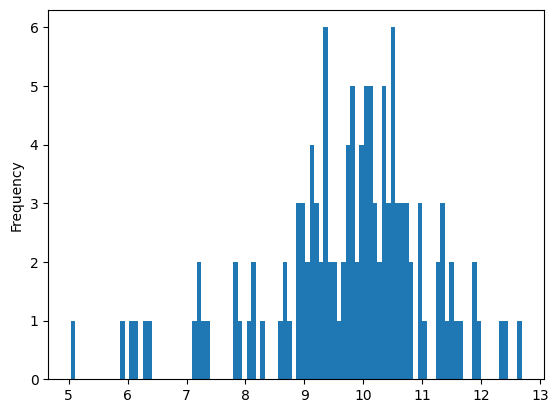

In [222]:
yearly_df["unit_price_log"].plot.hist(bins=100)

In [223]:
def get_price_index_from_regression(regression_results, prefix=""):
    yearly_results = regression_results.params.filter(like="year_")
    yearly_results = yearly_results.apply(lambda x: np.exp(x)) # maybe not minus 1
    base_year = min(yearly_results.index)
    base_coef = yearly_results[base_year]
    yearly_results = yearly_results / base_coef * 100

    yearly_results.name = f"{prefix}price_index"


    yearly_p_value = regression_results.pvalues.filter(like="year_")
    yearly_p_value.name = f"{prefix}p_value"

    results_df = pd.concat([yearly_results, yearly_p_value], axis=1)
    results_df = results_df.reset_index().rename(columns={"index": "year"})
    results_df["year"] = results_df["year"].apply(lambda x: x.split("_")[1])
    return results_df

In [224]:
X = yearly_df.drop(columns=metric_columns)
y = yearly_df[metric_columns[0]]

# Add a constant to the model (the intercept)
X = sm.add_constant(X)

# Fit the OLS model
ordinary_results = sm.OLS(y, X).fit()
# print(ordinary_results.summary())
ordinary_results_df = get_price_index_from_regression(ordinary_results)
ordinary_results_df["area_code"] = "13103"
ordinary_results_df["area"] = "Tokyo-to Minato-ku"
ordinary_results_df["growth"] = ordinary_results_df["price_index"].pct_change()
ordinary_results_df[["year", "area_code", "area", "price_index", "growth"]].round(2).to_csv("file.csv")

In [225]:
# Create an RLM model object
robust_model = sm.RLM(y, X)

# Fit the model
robust_results = robust_model.fit()

# Print out the summary of the regression results
# print(robust_results.summary())
robust_results_df = get_price_index_from_regression(robust_results)
robust_results_df

,year,price_index,p_value
0,2008,100.000000,0.374379
1,2009,199.761736,0.793727
2,2010,176.235802,0.959190
3,2011,81.225672,0.228297
4,2012,517.590363,0.198827
5,2013,81.160113,0.224155
6,2014,124.033423,0.689224
7,2015,73.374340,0.218253
8,2016,84.122591,0.286533
9,2017,39.720974,0.032784


<Axes: xlabel='year'>

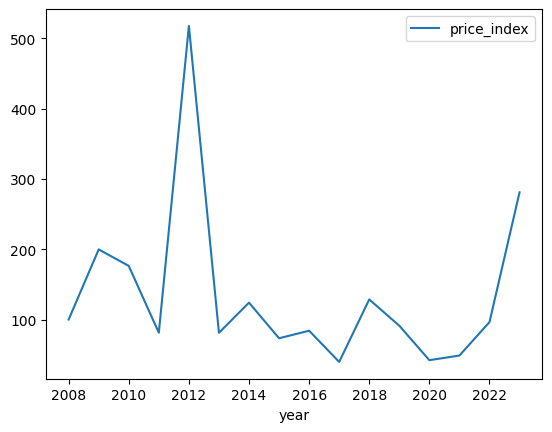

In [226]:
robust_results_df.plot.line(y="price_index", x="year")

<Axes: xlabel='year'>

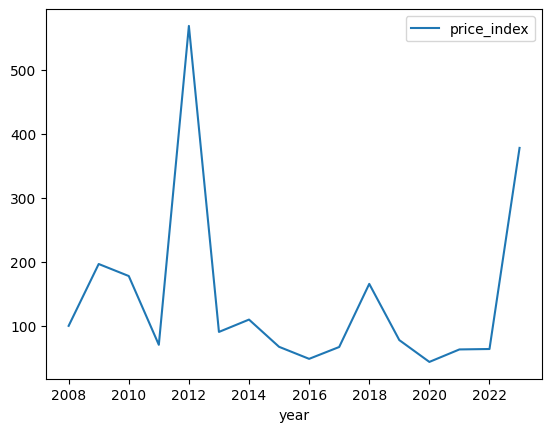

In [227]:
ordinary_results_df.plot.line(y="price_index", x="year")

<Axes: xlabel='year'>

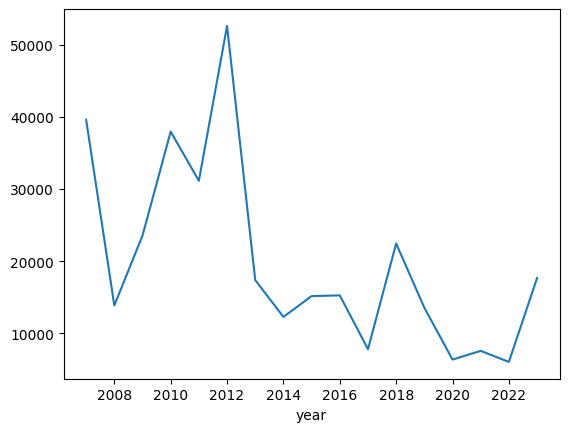

In [228]:
area_df_2 = asset_df[asset_df["area_code"] == area_code].reset_index(drop=True)
area_df_2.groupby(['year'])['unit_price'].apply(lambda x: np.exp(np.log(x).mean())).plot.line()